In [21]:
import torch
import wandb
import pprint
from tqdm.notebook import tqdm
import numpy as np

In [22]:
import os
os.environ["http_proxy"]="http://proxy61.iitd.ac.in:3128"
os.environ["https_proxy"]="http://proxy61.iitd.ac.in:3128"


In [23]:
track_columns = ['new node test average_precision',
 'train roc_auc',
 'new node val first_3_roc_auc',
 'new node test first_3_roc_auc',
 'new node test first_3_average_precision',
 'new node val average_precision',
 'new node val first_1_average_precision',
 'new node test first_1_average_precision',
 'new node test first_1_roc_auc',
 'new node test first_10_roc_auc',
 'new node val first_3_average_precision',
 'val average_precision',
 'val roc_auc',
 'new node val roc_auc',
 'new node val first_10_average_precision',
 'new node test roc_auc',
 'train average_precision',
 'test roc_auc',
 'new node val first_1_roc_auc',
 'new node val first_10_roc_auc',
 'test average_precision',
 'new node test first_10_average_precision']
import pandas as pd 
import wandb
api = wandb.Api()

runs = api.runs("fb-graph-proj/fb-graph-proj-dyglib", )

# for cnt, run in enumerate(tqdm(runs)):
#     # Find epoch with best avg precision
#     if cnt < 11:
#         val_key = 'val average_precision'
#         hist = run.history(samples = 200, keys = [val_key])[val_key]
#         best_epoch_num_test = np.argmax(hist[9::10])
#         best_epoch_num = np.argmax(hist)
#     else:
#         val_key = 'val_loss'
#         hist = run.history(samples = 200, keys = [val_key])[val_key]
#         best_epoch_num_test = np.argmin(hist[9::10])
#         best_epoch_num = np.argmin(hist)
#     print(best_epoch_num)
#     for key in track_columns:
#         hist = run.history(samples = 200, keys = [key])[key]
#         print(f"From {run.summary[key]} to ", end ="")
#         if 'test' in key:
#             run.summary[key] = hist[best_epoch_num_test]
#             print(f"{run.summary[key]}")
#         else:
#             run.summary[key] = hist[best_epoch_num]
#             print(f"{run.summary[key]}")
#     run.summary.update()

In [25]:
run = runs[0]
val_key = 'val average_precision'
hist = run.history(samples = 200, keys = [val_key])[val_key]
best_epoch_num_test = np.argmax(hist[9::10])

In [61]:
def get_average_over_last_five_epochs(run_id):
  # Takes wandb run id and returns average of last 5 readings of the following metrics
  # new node test average_precision
  # test average_precision
  # test roc_auc
  # new node test roc_auc
  api = wandb.Api()
  run = api.run(f"/fb-graph-proj/fb-graph-proj-dyglib/runs/{run_id}")
  index = torch.argmax(torch.tensor(run.history()["val average_precision"].tolist()))
  METRICS_LIST = ["new node test average_precision", "test average_precision", "test roc_auc", "new node test roc_auc"]
  avg_metric = {}
  for metric in METRICS_LIST:
    avg_metric[metric] = round(float(100 * torch.nanmean(torch.tensor(run.history()[metric].tolist()))), 2)
  print(run.config["dataset"])
  pprint.pprint(avg_metric)
  # return avg_metric

In [18]:
api = wandb.Api()
run = api.run(f"/fb-graph-proj/fb-graph-proj-dyglib/runs/jpp7vme0")
print(run.summary)
run.summary['test_loss'] = 0.2658
run.summary.update()

{'_timestamp': 1704864622.8613284, 'train_loss': {'min': 0.23194398468571345}, 'new node val average_precision': 0.9253885944374476, 'new node test average_precision': 0.9365360489713036, '_step': 41, 'test_loss': 0.2658, 'val average_precision': 0.9642710623015756, 'test average_precision': 0.9598691819415296, 'test roc_auc': {'max': 0.957818487394958}, 'train roc_auc': {'max': 0.9642339940649474}, 'new node test roc_auc': {'max': 0.9301795424690014}, 'train average_precision': 0.9642710623015756, '_wandb': {'runtime': 1468}, 'new node val_loss': {'min': 0.35462927964867136}, 'val roc_auc': {'max': 0.9642339940649474}, 'new node test loss': 0.3415547061269566, 'new node val roc_auc': {'max': 0.9190259221311476}, '_runtime': 1449.64683842659, 'val_loss': {'min': 0.255154035046321}}


In [10]:
import pandas as pd 
import wandb
api = wandb.Api()

runs = api.runs("fb-graph-proj/fb-graph-proj-dyglib", filters = {'dataset': "reddit"})

In [12]:
len(runs)

HTTPError: 400 Client Error: Bad Request for url: https://api.wandb.ai/graphql

In [5]:
run = runs[0]

In [7]:
hist = run.history(samples = 200, keys = ['train_acc_hist'])['train_acc_hist']

In [13]:
vals, bins = hist[0]['values'], hist[0]['bins']

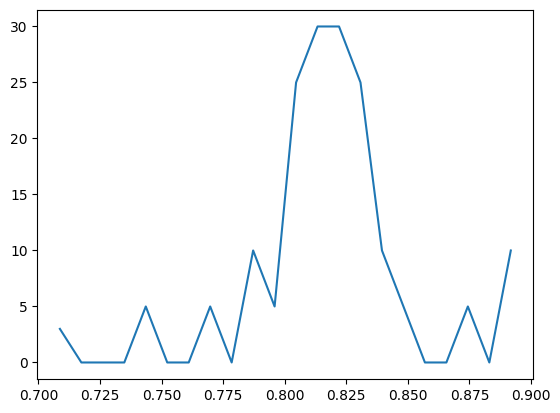

In [17]:
from matplotlib import pyplot as plt
plt.plot(bins[1:], vals)

In [23]:
runs = api.runs("fb-graph-proj/fb-graph-proj-dyglib", )

In [32]:
vals, bins

(array([4, 0, 1, 3, 4, 7, 0, 3, 2, 6]),
 array([0.00204809, 0.10064307, 0.19923805, 0.29783303, 0.39642801,
        0.495023  , 0.59361798, 0.69221296, 0.79080794, 0.88940292,
        0.9879979 ]))